<a href="https://colab.research.google.com/github/ShahadThobaiti/SR4NLP_project/blob/main/Baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install dependencies:

In [1]:
pip install sklearn xgboost nltk

In [2]:
# Download other NLTK dependencies before the first run
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')

# import all libraries used below
import csv, re, string
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score,f1_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Lemmatize tweets for baseline models.

In [8]:
def lemmatizer(tweet):
	"""
		remove stopwords, uncommon words, unknownwords etc.
	"""
	token_words = pos_tag(word_tokenize(tweet))
	lemmatizer = WordNetLemmatizer()
	root_words = []
	for word, tag in token_words:
		if not wordnet.synsets(word):
			continue
		if tag.startswith('NN'):
			word_lematizer = lemmatizer.lemmatize(word, pos='n')
		elif tag.startswith('VB'):
			word_lematizer = lemmatizer.lemmatize(word, pos='v')
		elif tag.startswith('JJ'):
			word_lematizer = lemmatizer.lemmatize(word, pos='a')
		elif tag.startswith('R'):
			word_lematizer = lemmatizer.lemmatize(word, pos='r')
		else:
			word_lematizer = lemmatizer.lemmatize(word)

		root_words.append(word_lematizer)

	filtered_words = [word.lower() for word in root_words if word not in set(stopwords.words('english'))]
	return " ".join(filtered_words)

def preprocess_text(tweet):
	"""
		remove punctuations, emojis, tabs, spaces, new lines, etc.
	"""
	text = re.sub('@[^\s]+|[hH]ttps\S\S\St.co(.)*|[0-9]|[^\w\s]','',tweet)
	# Regular expression to handle emojis, emoticons, and extraneous symbols 
	text = text.replace("\n"," ")
	text = text.translate(str.maketrans({a:None for a in string.punctuation}))
	text = text.lower()
	return lemmatizer(tweet)

Load tweets and lemmatize them.

In [5]:
from google.colab import drive
drive.mount('/content/drive')
with open('train.csv', 'r') as csv_file, open('test.csv', 'r') as csv_file2:
        csv_reader = csv.reader(csv_file, delimiter=',')
        csv_reader2 = csv.reader(csv_file2, delimiter=',')
        next(csv_reader, None)
        next(csv_reader2, None)
        x_train, y_train, x_test, y_test = [], [], [], []
        for row in csv_reader:
            x_train.append(preprocess_text(row[2]))
            if row[1] == 'Positive':
                y_train.append(2)
            elif row[1] == 'Negative':
                y_train.append(0)
            else:
                y_train.append(1)

        for row in csv_reader2:
            x_test.append(preprocess_text(row[2]))
            if row[1] == 'Positive':
                y_test.append(2)
            elif row[1] == 'Negative':
                y_test.append(0)
            else:
                y_test.append(1)

        print(x_train[1],y_train[1])
        print(len(x_train),len(y_train),len(x_test),len(y_test))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saudi Arabia acquired a 8.2% stake in Carnival (approximately 43.5 million shares). The shares were at very low prices and since the beginning of the year the stock has lost 81% of the value since the #cruise industry is struggling with the #coronav 0
1600 1600 400 400


Vectorize lemmatized tweets.

In [6]:
count_vect = CountVectorizer()
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

Build Baseline classifiers and regressors.

In [7]:
evaluations = ["Baseline Models", "Accuracy", "F1-Score"]
""" baseline classifier - Decision Tree """
dtmodel = DecisionTreeClassifier(criterion='entropy', random_state=1)
dtmodel.fit(x_train_tfidf,y_train)
predictions = dtmodel.predict(x_test_tfidf)
f1 = f1_score(y_test,predictions,average='micro')
evaluations.append(["Decision Tree",accuracy_score(y_test,predictions)*100,f1])

""" baseline classifier - Random Forest """
model = RandomForestClassifier(n_estimators=200)
model.fit(x_train_tfidf,y_train)
predictions = model.predict(x_test_tfidf)
f1 = f1_score(y_test,predictions,average='micro')
evaluations.append(["Random Forest",accuracy_score(y_test,predictions)*100,f1])

""" baseline regressor - Logistic Regression """
logmodel = LogisticRegression(random_state=400)
logmodel.fit(x_train_tfidf,y_train)
predictions = logmodel.predict(x_test_tfidf)
f1 = f1_score(y_test,predictions.round(),average='micro')
evaluations.append(["Logistic Regression",accuracy_score(y_test,predictions.round())*100,f1])

# """ baseline regressor - Gradient Boost Regressor """
gbmodel= GradientBoostingRegressor(n_estimators= 550, learning_rate= 0.1, max_depth= 3)
gbmodel.fit(x_train_tfidf,y_train)
predictions = gbmodel.predict(x_test_tfidf)
f1 = f1_score(y_test,predictions.round(),average='micro')
evaluations.append(["Gradient Boost Regression",accuracy_score(y_test,predictions.round())*100,f1])

# """ baseline regressor - XGBoost """
xgbmodel=XGBClassifier(random_state=22,learning_rate=0.9)
xgbmodel.fit(x_train_tfidf,y_train)
predictions = xgbmodel.predict(x_test_tfidf)
f1 = f1_score(y_test,predictions.round(),average='micro')
evaluations.append(["XGBoost Regression",accuracy_score(y_test,predictions.round())*100,f1])

print(evaluations)

['Baseline Models', 'Accuracy', 'F1-Score', ['Decision Tree', 38.75, 0.3875], ['Random Forest', 51.24999999999999, 0.5125], ['Logistic Regression', 51.74999999999999, 0.5175], ['Gradient Boost Regression', 33.0, 0.33], ['XGBoost Regression', 48.5, 0.485]]


## BERT Model

In [1]:
from bert_sklearn import BertClassifier
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix




In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
X_train = list(train['processed tweet'])
y_train = list(train['Sentiment'])

X_test =list(test['processed tweet'])
y_test = list(test['Sentiment'])


In [4]:
model = BertClassifier()
model.fit(X_train, y_train)

Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 1440, validation data size: 160


Training  :   0%|                                        | 0/45 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/bert_sklearn/model/pytorch_pretrained/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/python_arg_parser.cpp:1055.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
Validating: 100%|███████████████████████████████| 20/20 [00:36<00:00,  1.81s/it]

Epoch 1, Train loss: 1.0832, Val loss: 1.0804, Val accy: 44.38%



Validating: 100%|███████████████████████████████| 20/20 [00:36<00:00,  1.81s/it]

Epoch 2, Train loss: 0.9560, Val loss: 0.9960, Val accy: 50.62%



Validating: 100%|███████████████████████████████| 20/20 [00:36<00:00,  1.80s/it]

Epoch 3, Train loss: 0.6978, Val loss: 1.0654, Val accy: 53.75%


BertClassifier(do_lower_case=True,
               label_list=array(['Negative', 'Neutral', 'Positive'], dtype='<U8'))

In [5]:
predictions = model.predict(X_test)

Predicting: 100%|███████████████████████████████| 50/50 [00:51<00:00,  1.02s/it]


In [6]:
f1 = f1_score(y_test, predictions, average='micro')*100
accuracy = accuracy_score(y_test, predictions)*100

In [7]:
print('Accuracy = %.2f'% accuracy)
print('F1 score = %.2f'% f1)

Accuracy = 58.25
F1 score = 58.25


In [8]:
model.validation_fraction

0.1

In [9]:
model.get_params()

{'bert_config_json': None,
 'bert_model': 'bert-base-uncased',
 'bert_vocab': None,
 'do_lower_case': True,
 'epochs': 3,
 'eval_batch_size': 8,
 'fp16': False,
 'from_tf': False,
 'gradient_accumulation_steps': 1,
 'ignore_label': None,
 'label_list': array(['Negative', 'Neutral', 'Positive'], dtype='<U8'),
 'learning_rate': 2e-05,
 'local_rank': -1,
 'logfile': 'bert_sklearn.log',
 'loss_scale': 0,
 'max_seq_length': 128,
 'num_mlp_hiddens': 500,
 'num_mlp_layers': 0,
 'random_state': 42,
 'restore_file': None,
 'train_batch_size': 32,
 'use_cuda': True,
 'validation_fraction': 0.1,
 'warmup_proportion': 0.1}

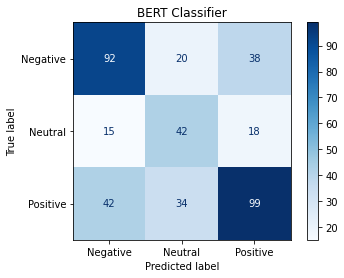

In [30]:
cm = confusion_matrix(predictions, y_test)
class_labels = ['Negative', 'Neutral', 'Positive']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('BERT Classifier')
plt.savefig("BERT_cm.png", dpi = 300)
plt.show()

